In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named '__main__.prediction_pipeline'; '__main__' is not a package

# Mark sub-cohorts of PFC cohort

In [2]:
data_dir_agonised = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

In [3]:
sys_phen_ago = load_sys_phenotypes(data_dir_agonised,root_dir="CBR 159")

111 candidates summary files
Initially 632 rows, 631 unique IDs
Finally 378 rows, 378 unique IDs


In [4]:
sys_phen_ago["time_col"] = pd.to_datetime(sys_phen_ago["Date"],format="%d/%m/%Y")
sys_phen_ago.sort_values("time_col",inplace=True)

In [5]:
sys_phen_ago.head()

,Nickname,Analyzer ID,Date,Time,Rack,ID,Sample Inf.,Order Type,Reception Date,Measurement Mode,...,HFLC#/M,HFLC%/M,BA-D#/M,BA-D%/M,NE-SSC/M,NE-SFL/M,NE-FSC/M,IP SUS(WBC)Atypical Lympho?,IP SUS(WBC)Blasts?,time_col
206,XN-1000-1-A,XN-20^12829,22/05/2018,10:20:32,,C19GWU_CRP,M,Manual (Open),22/05/2018 10:18:50,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-22
207,XN-1000-1-A,XN-20^12829,22/05/2018,10:18:45,,C19GWU_ADP,M,Manual (Open),22/05/2018 10:16:42,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-22
299,XN-1000-1-A,XN-20^12829,23/05/2018,11:02:56,,C19H48_CRP,M,Manual (Open),23/05/2018 11:01:14,WB,...,*,*,*,*,*,*,*,NaN,NaN,2018-05-23
306,XN-1000-1-A,XN-20^12829,23/05/2018,13:36:25,,C19H80_ADP,M,Manual (Open),23/05/2018 13:34:43,WB,...,*,*,*,*,*,*,*,NaN,1.0,2018-05-23
307,XN-1000-1-A,XN-20^12829,23/05/2018,13:34:48,,C19H80_RESTING,M,Manual (Open),23/05/2018 13:33:05,WB,...,*,*,*,*,*,*,*,NaN,1.0,2018-05-23


In [7]:
sys_phen = load_sys_phenotypes(data_dir)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


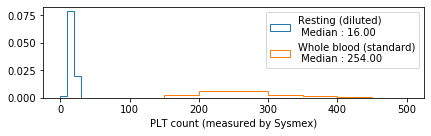

In [9]:
plt.figure(figsize=(6,2))
plt.hist(sys_phen_ago.loc[sys_phen_ago.ID.str.contains("RESTING")].PLT,range=(0,500),
         histtype="step",density=True,bins=50,
         label="Resting (diluted)\n Median : %.2f" % sys_phen_ago.loc[sys_phen_ago.ID.str.contains("RESTING")].PLT.median())
plt.hist(sys_phen.PLT,range=(0,500),histtype="step",density=True,
         label = "Whole blood (standard)\n Median : %.2f" % sys_phen.PLT.median())
plt.xlabel("PLT count (measured by Sysmex)")
plt.legend()
plt.tight_layout()

In [8]:
sys_phen.head()

,Nickname,Analyzer ID,Date,Time,Rack,ID,Sample Inf.,Order Type,Reception Date,Measurement Mode,...,IG#/M,IG%/M,NEUT#&/M,NEUT%&/M,NE-SSC/M,NE-SFL/M,NE-FSC/M,IP SUS(RBC)Iron Deficiency?,HCT/M,RDW-CV/M
694,XN-1000-1-A,XN-20^12829,09/04/2018,08:13:17,,C196EW,B,Manual,09/04/2018 08:11:30,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,XN-1000-1-A,XN-20^12829,29/11/2017,08:13:33,,C18S65,B,Manual,29/11/2017 08:11:46,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,XN-1000-1-A,XN-20^12829,19/07/2017,08:14:17,,C18967,B,Manual,19/07/2017 08:12:30,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,XN-1000-1-A,XN-20^12829,08/08/2017,08:16:58,,C18BBQ,B,Manual,08/08/2017 08:15:11,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,XN-1000-1-A,XN-20^12829,20/04/2018,08:23:04,,C199K8,B,Manual (Open),20/04/2018 08:21:16,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sys_phen_ago_REST = sys_phen_ago.loc[sys_phen_ago.ID.str.contains("REST")]
sys_phen_ago_REST["ID"] = sys_phen_ago_REST["ID"].str.split("_",expand=True)[0]

In [19]:
comp = pd.merge(sys_phen_ago_REST[["ID","PLT"]],sys_phen[["ID","PLT"]],suffixes=("_REST","_WB"),left_on="ID",right_on="ID")

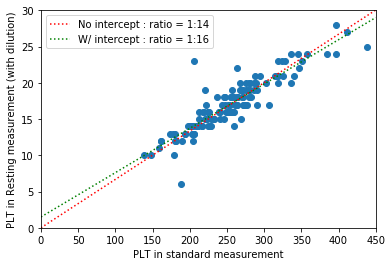

In [30]:
plt.scatter(comp.PLT_WB, comp.PLT_REST)
plt.xlim((0,450))
plt.ylim((0,30))

lm1 = LinearRegression(fit_intercept=False).fit(np.reshape(comp.PLT_WB.values,(-1,1)),comp.PLT_REST)
plt.plot([0,450],[0,lm1.coef_*450],":",c="red",label="No intercept : ratio = 1:%d" % (1./lm1.coef_))
lm2 = LinearRegression(fit_intercept=True).fit(np.reshape(comp.PLT_WB.values,(-1,1)),comp.PLT_REST)
plt.plot([0,450],[lm2.intercept_,lm2.intercept_ + lm2.coef_*450],":",c="green",label="W/ intercept : ratio = 1:%d" % (1./lm2.coef_))

plt.xlabel("PLT in standard measurement")
plt.ylabel("PLT in Resting measurement (with dilution)")

plt.legend()

In [7]:
sys_features = sys_phen.set_index("ID")[SYS_FEATURES]
assert sys_features.shape[0] == sys_phen.ID.nunique()

In [8]:
sys_features.head()

,PLT,MPV,PDW,PCT,IPF
ID,,,,,
C0WX8R,265.0,10.9,12.9,0.28,4.3
C0WX14,281.0,9.3,9.8,0.24,2.2
C0WX6V,281.0,10.1,11.2,0.27,3.4
C0WX4Z,259.0,10.2,11.8,0.25,2.3
C0WX7T,273.0,11.1,13.7,0.29,3.2


In [9]:
X = sys_features
X = X.values

In [10]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=50).fit(
    X
)

3 BKPS


<Figure size 720x288 with 0 Axes>

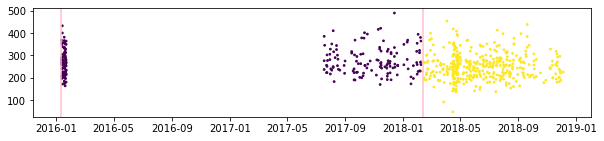

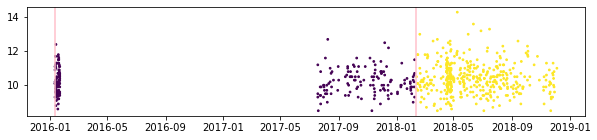

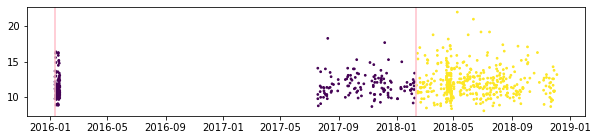

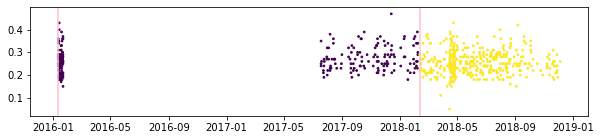

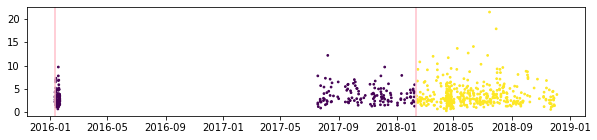

In [11]:
bkps = algo_c.predict(pen=1.6)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

sys_features["cohort"] = 0
sys_features["rank"] = np.arange(sys_features.shape[0])
for b in bkps[1:]:
    sys_features.loc[sys_features["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(sys_phen.time_col,X[:,i],s=3,c=sys_features.cohort)
    for b in bkps[:-1]:
        plt.axvline(sys_phen.time_col.iloc[b],c="pink")

# Mark sub-cohorts of INT cohort

In [12]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [13]:
int_phen.sort_values("DateTime",inplace=True)
int_features = int_phen.set_index("SampleNo")[SYS_FEATURES]
X = int_features.values

In [14]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=1000).fit(
    X
)
bkps = algo_c.predict(pen=1.6)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

10 BKPS


<Figure size 720x288 with 0 Axes>

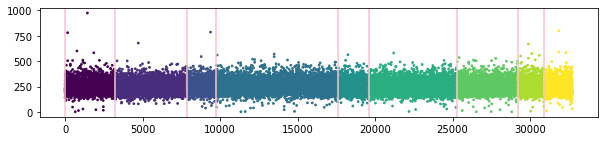

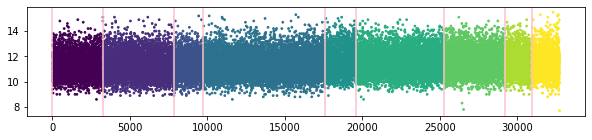

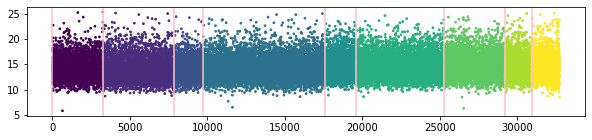

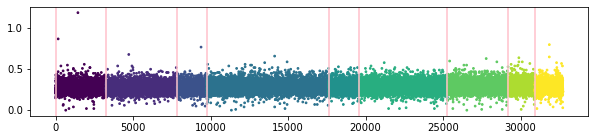

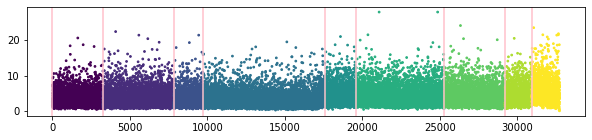

In [15]:
int_features["cohort"] = sys_features.cohort.max() + 1
int_features["rank"] = np.arange(int_features.shape[0])
for b in bkps[1:]:
    int_features.loc[int_features["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(int_features["rank"],X[:,i],s=3,c=int_features.cohort)
    for b in bkps[:-1]:
        plt.axvline(int_features["rank"].iloc[b],c="pink")

# age & sex

In [16]:
sys_info, int_info = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [17]:
sys_info.head()

,SEX,AGE
SAMPLE_ID,,
C0WX14,2,67.0
C0WX4Z,2,63.0
C0WX6V,2,64.0
C0WX7T,2,70.0
C0WX8R,2,71.0


In [18]:
int_info.head()

,SEX,AGE
SampleNo,,
INT_116_6580100,1,58.8
INT_116_6580000,2,22.6
INT_116_4555900,2,59.4
INT_116_4555800,2,21.3
INT_116_4556000,1,49.3


# Gather cohort + features + info

In [19]:
# merge sys
sys = pd.merge(sys_features, sys_info,left_index=True,right_index=True,how="inner")
print("%d samples in Sysmex cohort" % sys.shape[0])
sys.head()

635 samples in Sysmex cohort


,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
C0WX8R,265.0,10.9,12.9,0.28,4.3,0,0,2,71.0
C0WX14,281.0,9.3,9.8,0.24,2.2,0,1,2,67.0
C0WX6V,281.0,10.1,11.2,0.27,3.4,0,2,2,64.0
C0WX4Z,259.0,10.2,11.8,0.25,2.3,0,3,2,63.0
C0WX7T,273.0,11.1,13.7,0.29,3.2,0,4,2,70.0


In [20]:
# merge int
int_ = pd.merge(int_features, int_info,left_index=True,right_index=True,how="inner")
print("%d samples in Interval cohort" % int_.shape[0])
int_.head()

32727 samples in Interval cohort


,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
SampleNo,,,,,,,,,
INT_116_6580100,212.0,11.0,13.8,0.22,1.7,2,0,1,58.8
INT_116_6580000,235.0,11.4,14.9,0.27,2.8,2,1,2,22.6
INT_116_4555900,143.0,11.9,13.0,0.15,2.4,2,2,2,59.4
INT_116_4555800,197.0,12.3,16.3,0.25,3.5,2,3,2,21.3
INT_116_4556000,265.0,11.4,14.3,0.30,1.6,2,4,1,49.3


In [21]:
all_ = pd.concat([sys,int_],axis=0)
all_.head()

,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
C0WX8R,265.0,10.9,12.9,0.28,4.3,0,0,2,71.0
C0WX14,281.0,9.3,9.8,0.24,2.2,0,1,2,67.0
C0WX6V,281.0,10.1,11.2,0.27,3.4,0,2,2,64.0
C0WX4Z,259.0,10.2,11.8,0.25,2.3,0,3,2,63.0
C0WX7T,273.0,11.1,13.7,0.29,3.2,0,4,2,70.0


In [22]:
cohort_cols = pd.get_dummies(all_["cohort"])

In [23]:
X = pd.concat([all_[["SEX","AGE"]],cohort_cols],axis=1)
Y = all_[SYS_FEATURES]

In [24]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
coef = lm.coef_
cohort_coef = coef[:,2:]
print(cohort_coef.shape)

(5, 11)


In [25]:
for i in np.unique(all_.cohort):
    Y.loc[all_.cohort == i] -= cohort_coef[:,i]

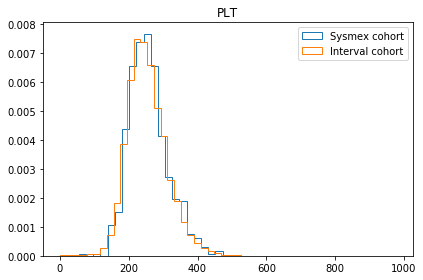

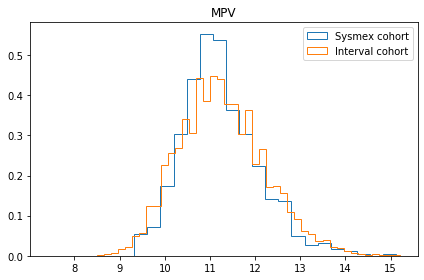

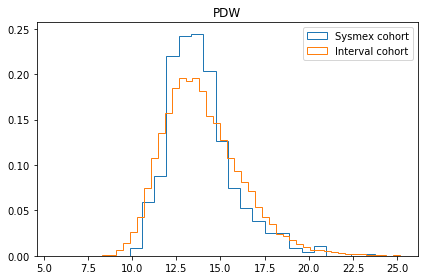

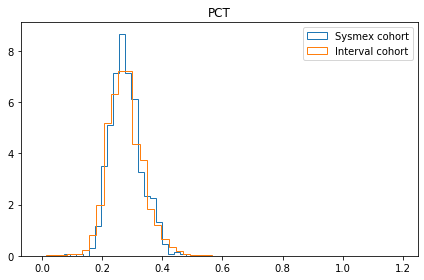

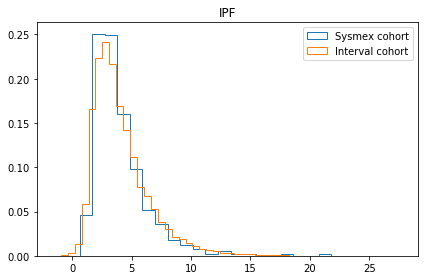

In [26]:
for col in SYS_FEATURES:
    plt.figure()
    plt.hist(Y.loc[all_.cohort.isin(sys.cohort.unique().tolist()),col],density=True,bins=20,histtype="step",label="Sysmex cohort")
    plt.hist(Y.loc[~all_.cohort.isin(sys.cohort.unique().tolist()),col],density=True,bins=50,histtype="step",label="Interval cohort")
    plt.title(col)
    plt.legend()
    plt.tight_layout()

# Export

In [27]:
# Sysmex features to be used later
Y[SYS_FEATURES].to_csv("%s/processed/sysmex_features.csv" % data_dir,index=True)
# int_phen, for Intrument and Filename
int_phen[["SampleNo","Instrument","FileName"]].to_csv("%s/processed/interval_instrument_filename.csv" % data_dir,index=True)